In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Noto Sans Bengali', 'FreeSerif']
print("Current font:", plt.rcParams['font.family'])


# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from typing import List, Dict

Current font: ['Noto Sans Bengali', 'FreeSerif']


In [2]:
# # Check if GPUs are available
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#     try:
#         for gpu in gpus:
#             # Check if memory growth is already set
#             if not tf.config.experimental.get_memory_growth(gpu):
#                 tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

#             # Check if virtual device configuration is already set
#             if not tf.config.experimental.get_virtual_device_configuration(gpu):
#                 tf.config.experimental.set_virtual_device_configuration(
#                     gpu,
#                     # 3GB for safety
#                     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)]  # Set VRAM limit (in MB)
#                 )
        
#         print("GPU memory growth enabled.")

#     except RuntimeError as e:
#         print(f"Warning: {e} - Skipping GPU reconfiguration.")


GPU memory growth enabled.


2025-08-09 05:21:20.878739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-09 05:21:21.052703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-09 05:21:21.053061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# --- Configuration ---
BASE_DATASET_DIR = '/data'                      # Root directory to scan
# Can be int, None, -1, or "inf"
TRAIN_LIMIT = "inf"                             # Number of images to use in training (before caption expansion)
VALIDATE_IMAGES = True                          # Ensure image files exist before using

In [4]:
from caption_parsers import collect_all_caption_data

# --- Load all caption data from supported formats ---
caption_mapping: Dict[str, List[str]] = collect_all_caption_data(
    base_dir=BASE_DATASET_DIR,
    validate_images=VALIDATE_IMAGES
)

🔍 Scanning directories in /data...

➡️  Parsing BAN-Cap_captiondata.csv (folder: /data/BAN-Cap English-Bangla Image Descriptions Dataset, 40455 rows)...
  → Finished parsing BAN-Cap_captiondata.csv. Total valid entries: 40455.

➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning_cat.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning_group.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing captioning_male.xlsx (6682 rows)...
  → Row 6682/6682...
➡️  Parsing JSON: captions.json...
  → Finished parsing captions.json. Total valid entries: 9154.


In [5]:
# --- Shuffle and Prepare Dataset ---
image_paths = list(caption_mapping.keys())
random.shuffle(image_paths)

# Handle different TRAIN_LIMIT formats
if isinstance(TRAIN_LIMIT, str) and TRAIN_LIMIT.strip().lower() == "inf":
    train_image_paths = image_paths
elif TRAIN_LIMIT is None or TRAIN_LIMIT == -1:
    train_image_paths = image_paths
elif isinstance(TRAIN_LIMIT, (int, float)) and TRAIN_LIMIT > 0:
    train_image_paths = image_paths[:int(TRAIN_LIMIT)]
else:
    raise ValueError(f"Invalid TRAIN_LIMIT value: {TRAIN_LIMIT}")

print(f"✅ Using {len(train_image_paths)} image paths for training")

In [6]:
# Build flat caption list and matching image list
train_captions: List[str] = []
img_name_vector: List[str] = []

for image_path in train_image_paths:
    captions = caption_mapping[image_path]
    train_captions.extend([f"<start> {cap} <end>" for cap in captions])
    img_name_vector.extend([image_path] * len(captions))

✅ Total training image paths selected: 8000
📌 First caption: <start>  <start> সবুজ সোয়েটশার্টে বসে একটি মেয়ে এবং অপর একটি মেয়ে নীল লকারে হেলান দিয়ে আছে <end>  <end>


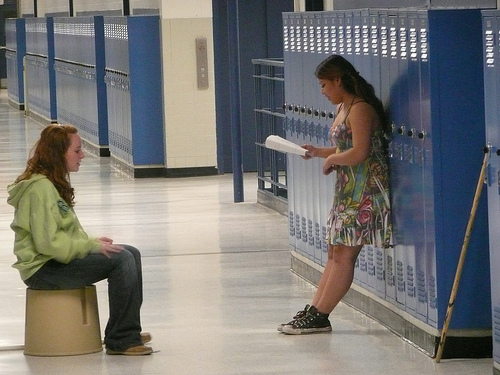

In [7]:
# --- Sample Output ---
print(f"✅ Total training image paths selected: {len(train_image_paths)}")
print(f"📌 First caption: {train_captions[0]}")
Image.open(img_name_vector[0]).show()

Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:

Resizing the image to 299px by 299px
Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [8]:
import tensorflow as tf
import numpy as np
import cv2

IMG_SIZE = (299, 299)

def load_image_cv(path):
    path = path.numpy().decode() if isinstance(path, tf.Tensor) else path
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = tf.keras.applications.inception_v3.preprocess_input(img.astype(np.float32))
    return img, path

def safe_load_image(path):
    try:
        return load_image_cv(path)
    except Exception as e:
        msg = f"⚠️ Skipping unreadable image: {path.numpy().decode()}"
        print(msg)
        with open("/results/skipped_images.log", "a", encoding="utf-8") as log_file:
            log_file.write(msg + "\n")
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32), path.numpy().decode()

def tf_safe_load_image(path):
    image, path_str = tf.py_function(safe_load_image, [path], [tf.float32, tf.string])
    image.set_shape([*IMG_SIZE, 3])
    path_str.set_shape([])
    return image, path_str


Initialize InceptionV3 and load the pretrained Imagenet weights
Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
After all the images are passed through the network, you pickle the dictionary and save it to disk.

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2025-08-09 05:22:26.554903: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-09 05:22:26.556897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-09 05:22:26.557259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-09 05:22:26.557601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built witho

Caching the features extracted from InceptionV3
You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can:

install tqdm:

!pip install tqdm

Import tqdm:

from tqdm import tqdm

Change the following line:

for img, path in image_dataset:

to:

for img, path in tqdm(image_dataset):

In [10]:
from tqdm import tqdm

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  tf_safe_load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64) 

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

  0%|                                                                                                         | 0/125 [00:00<?, ?it/s]2025-08-09 05:22:35.427804: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2025-08-09 05:22:38.137372: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-09 05:22:38.139251: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-09 05:22:38.139319: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-08-09 05:22:38.140838: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-09 05:22:38.141018: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PA

Preprocess and tokenize the captions
First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
You then create word-to-index and index-to-word mappings.
Finally, you pad all sequences to be the same length as the longest one.

In [11]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# Choose the top 5000 words from the vocabulary
top_k = 10000 # can adjust to 5000 if needed
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=top_k,
    oov_token="<unk>",  # will replace unknown words
    filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '  # removes unwanted characters
)
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [13]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [14]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [15]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [16]:
print("✅ '<start>' token index:", tokenizer.word_index.get('<start>', '❌ Not found'))
print("✅ '<end>' token index:", tokenizer.word_index.get('<end>', '❌ Not found'))
print("✅ '<unk>' token index:", tokenizer.word_index.get('<unk>', '❌ Not found'))
print("✅ '<pad>' token index:", tokenizer.word_index.get('<pad>', '❌ Not found'))

✅ '<start>' token index: 2
✅ '<end>' token index: 3
✅ '<unk>' token index: 1
✅ '<pad>' token index: 0


In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(22675, 22675, 5689, 5689)

Create a tf.data dataset for training
Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [20]:
import tensorflow as tf
import numpy as np
import os

# Configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# -------- SAFE LOADING FUNC -------- #
# Safe loader
def safe_map_func(img_name, cap):
    try:
        img_path = img_name.decode('utf-8') + '.npy'
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"❌ File not found: {img_path}")
        img_tensor = np.load(img_path).astype(np.float32)
        return img_tensor, cap
    except Exception as e:
        print(f"⚠️ Skipping sample due to error: {e}")
        dummy_tensor = np.zeros((attention_features_shape, features_shape), dtype=np.float32)
        # Return dummy caption of same shape as real ones but filled with -1
        return dummy_tensor, np.full_like(cap, fill_value=-1)

In [22]:
def tf_safe_map_func(img_name, cap):
    img_tensor, cap = tf.numpy_function(
        safe_map_func, [img_name, cap], [tf.float32, tf.int32]
    )
    img_tensor.set_shape([attention_features_shape, features_shape])
    cap.set_shape([max_length])
    return img_tensor, cap

In [23]:
# -------- DATASET PIPELINE -------- #
# Dataset pipeline

# Create dataset from filenames and caption indices
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Apply mapping safely
dataset = dataset.map(tf_safe_map_func, num_parallel_calls=tf.data.AUTOTUNE)

# Filter out samples where all caption tokens are -1
dataset = dataset.filter(lambda img, cap: tf.reduce_any(tf.not_equal(cap, -1)))

# Shuffle, batch and prefetch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [24]:
# -------- VALIDATION DATASET PIPELINE -------- #
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Apply safe map
val_dataset = val_dataset.map(tf_safe_map_func, num_parallel_calls=tf.data.AUTOTUNE)

# Filter out samples where all caption tokens are -1
val_dataset = val_dataset.filter(lambda img, cap: tf.reduce_any(tf.not_equal(cap, -1)))

# Batch and prefetch (no shuffle for validation)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

val_steps = len(img_name_val) // BATCH_SIZE

Model:

Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
You squash that to a shape of (64, 2048).
This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
The RNN (here GRU) attends over the image to predict the next word.

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [27]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [28]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [30]:
checkpoint_path = "/results/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [31]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Training:

You extract the features stored in the respective .npy files and then pass those features through the encoder.
The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
The decoder returns the predictions and the decoder hidden state.
The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
Use teacher forcing to decide the next input to the decoder.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [32]:
from tqdm import tqdm
import numpy as np

# --- Early Stopping Parameters ---
patience = 5  # Stop after 5 epochs without improvement
best_loss = np.inf
wait = 0
best_epoch = 0
best_ckpt_path = "/results/best_model"

In [33]:
# adding this in a separate cell because if you run the training cell
# many times, the arrays will be reset
loss_plot_train = []
loss_plot_val = []

In [34]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)  # Teacher forcing

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [35]:
@tf.function
def val_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    return loss, total_loss

In [36]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_train_loss = 0.0
    total_val_loss = 0.0

    # --- Training loop with progress bar ---
    pbar_train = tqdm(enumerate(dataset), total=num_steps, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
    for batch, (img_tensor, target) in pbar_train:
        batch_loss, t_loss = train_step(img_tensor, target)
        total_train_loss += t_loss
        pbar_train.set_postfix({"Batch Loss": f"{batch_loss.numpy() / int(target.shape[1]):.4f}"})

    epoch_train_loss = total_train_loss / num_steps
    loss_plot_train.append(epoch_train_loss)

    # --- Validation loop ---
    pbar_val = tqdm(enumerate(val_dataset), total=val_steps, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch")
    for batch, (img_tensor, target) in pbar_val:
        batch_loss, t_loss = val_step(img_tensor, target)
        total_val_loss += t_loss
        pbar_val.set_postfix({"Batch Loss": f"{batch_loss.numpy() / int(target.shape[1]):.4f}"})

    epoch_val_loss = total_val_loss / val_steps
    loss_plot_val.append(epoch_val_loss)

    # --- Save regular checkpoint every 5 epochs ---
    if epoch % 5 == 0:
        ckpt_manager.save()

    # --- Epoch summary ---
    print(f"\nEpoch {epoch + 1} Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")
    print(f"Time taken: {time.time() - start:.2f} sec")

    # --- Early Stopping on Validation Loss ---
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_epoch = epoch
        wait = 0
        print(f"✅ Validation loss improved to {best_loss:.6f}, saving best model...")
        best_ckpt_manager = tf.train.CheckpointManager(ckpt, best_ckpt_path, max_to_keep=1)
        best_ckpt_manager.save()
    else:
        wait += 1
        print(f"No improvement for {wait} epoch(s).")
        if wait >= patience:
            print(f"⏹ Early stopping triggered at epoch {epoch+1}.")
            print(f"Best model saved at: {best_ckpt_path}")
            break

Epoch 1/100 [Train]: 355batch [05:24,  1.09batch/s, Batch Loss=1.1616]                                                                
Epoch 1/100 [Val]: 89batch [01:27,  1.02batch/s, Batch Loss=1.2648]                                                                   



Epoch 1 Train Loss: 1.378244 | Val Loss: 1.208951
Time taken: 414.64 sec
✅ Validation loss improved to 1.208951, saving best model...


Epoch 2/100 [Train]:   0%|                                                                                 | 0/354 [00:00<?, ?batch/s]2025-08-09 05:36:08.241438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 732 of 1000
2025-08-09 05:36:10.978692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
Epoch 2/100 [Train]: 355batch [04:13,  1.40batch/s, Batch Loss=0.9293]                                                                
Epoch 2/100 [Val]: 89batch [00:59,  1.50batch/s, Batch Loss=1.1430]                                                                   



Epoch 2 Train Loss: 1.083268 | Val Loss: 1.088002
Time taken: 312.86 sec
✅ Validation loss improved to 1.088002, saving best model...


Epoch 3/100 [Train]:   0%|                                                                                 | 0/354 [00:00<?, ?batch/s]2025-08-09 05:41:22.591380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 765 of 1000
2025-08-09 05:41:24.633192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
Epoch 3/100 [Train]: 355batch [04:11,  1.41batch/s, Batch Loss=0.7984]                                                                
Epoch 3/100 [Val]: 89batch [01:10,  1.26batch/s, Batch Loss=1.1165]                                                                   



Epoch 3 Train Loss: 0.947375 | Val Loss: 1.064596
Time taken: 321.87 sec
✅ Validation loss improved to 1.064596, saving best model...


Epoch 4/100 [Train]:   0%|                                                                                 | 0/354 [00:00<?, ?batch/s]2025-08-09 05:46:45.492692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 793 of 1000
2025-08-09 05:46:47.430304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
Epoch 4/100 [Train]: 355batch [04:14,  1.40batch/s, Batch Loss=0.7465]                                                                
Epoch 4/100 [Val]: 89batch [01:00,  1.46batch/s, Batch Loss=1.1316]                                                                   



Epoch 4 Train Loss: 0.861717 | Val Loss: 1.067075
Time taken: 315.02 sec
No improvement for 1 epoch(s).


Epoch 5/100 [Train]:   0%|                                                                                 | 0/354 [00:00<?, ?batch/s]2025-08-09 05:52:00.532603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 925 of 1000
2025-08-09 05:52:01.307417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
Epoch 5/100 [Train]: 355batch [04:13,  1.40batch/s, Batch Loss=0.7957]                                                                
Epoch 5/100 [Val]: 89batch [00:59,  1.48batch/s, Batch Loss=1.1362]                                                                   



Epoch 5 Train Loss: 0.796299 | Val Loss: 1.070837
Time taken: 313.64 sec
No improvement for 2 epoch(s).


Epoch 6/100 [Train]:   0%|                                                                                 | 0/354 [00:00<?, ?batch/s]2025-08-09 05:57:22.431172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 889 of 1000
2025-08-09 05:57:23.450314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
Epoch 6/100 [Train]: 355batch [04:20,  1.36batch/s, Batch Loss=0.7734]                                                                
Epoch 6/100 [Val]: 89batch [01:00,  1.47batch/s, Batch Loss=1.1655]                                                                   



Epoch 6 Train Loss: 0.738230 | Val Loss: 1.095127
Time taken: 322.26 sec
No improvement for 3 epoch(s).


Epoch 7/100 [Train]:   0%|                                                                                 | 0/354 [00:00<?, ?batch/s]2025-08-09 06:02:36.548253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 701 of 1000
2025-08-09 06:02:39.815437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
Epoch 7/100 [Train]: 355batch [04:16,  1.39batch/s, Batch Loss=0.6866]                                                                
Epoch 7/100 [Val]:  12%|███████                                                 | 11/88 [00:08<00:58,  1.32batch/s, Batch Loss=1.0477]

KeyboardInterrupt



In [ ]:
# --- Loss Plot after Training ---
early_stop_epoch = best_epoch + 1  # convert to 1-based for display

fig = plt.figure(figsize=(6, 4))
plt.plot(loss_plot_train, color='r', label='Training Loss')
plt.plot(loss_plot_val, color='b', label='Validation Loss')

# Mark early stop
plt.axvline(
    x=early_stop_epoch - 1,
    color='g',
    linestyle='--',
    linewidth=1.5,
    label=f'Early Stop @ Epoch {early_stop_epoch}'
)

# Shade after early stop
plt.axvspan(
    early_stop_epoch - 1,
    len(loss_plot_train) - 1,
    color='gray',
    alpha=0.2,
    label='Training stopped here'
)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss with Early Stopping')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("/results/loss.png", dpi=300)
plt.show()

Caption!

The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
Stop predicting when the model predicts the end token.
And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image_cv(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
import math

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    len_result = len(result)
    cols = math.ceil(math.sqrt(len_result))
    rows = math.ceil(len_result / cols)

    fig = plt.figure(figsize=(15, 15))

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(rows, cols, l + 1)
        ax.set_title(result[l])
        plt.axis('off')
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.savefig("/results/attention.png", bbox_inches='tight')
    plt.show()

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))

ii=img_name_val[rid]
print(ii)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
Image.open(ii)
#plot_attention(image, result, attention_plot)